In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# Pour avoir un plot 3D interactif
#%matplotlib widget
np.random.seed(42)

# Préparation des données

In [77]:
files = [
    '../data/data_limagrain_2024/OSR BN51776 lot1.xlsx',
    '../data/data_limagrain_2024/OSR lot 2.xlsx',
    '../data/data_limagrain_2024/OSR Lot 3.xlsx',
    '../data/data_limagrain_2024/OSR lot 4.xlsx'
]

In [78]:
labels = pd.read_excel('../data/data_limagrain_2024/génotypage_correct.xlsx')

In [79]:
np.unique(labels['Fertilité'], return_counts=True)

(array([ 0.,  1., nan]), array([1986, 4851,  603]))

In [80]:
df_list = []
for i, f in enumerate(files):
    df_tmp = pd.read_excel(f)
        
    # get seed ID
    df_tmp['ColNr'] = df_tmp['ColNr'].astype('str')
    df_tmp['ColNr'].where(df_tmp['ColNr'].astype('int64')>=10, other='0'+df_tmp['ColNr'], inplace=True)
    df_tmp['TrayNr'] = df_tmp['TrayNr'].astype('str')
    df_tmp['TrayNr'].where(df_tmp['TrayNr'].astype('int64')>=10, other='0'+df_tmp['TrayNr'], inplace=True)
    df_tmp['ID'] = 'T' + df_tmp['TrayNr'] + df_tmp['RowNr'] + df_tmp['ColNr']
    
    # merge labels-df
    labels_tmp = labels[labels['Lot']==i+1]
    df_tmp = pd.merge(df_tmp, labels_tmp, on='ID')
    
    df_list.append(df_tmp)

In [144]:
df = pd.concat(df_list)

In [145]:
df.head()

,SeedNr,TrayNr,RowNr,ColNr,Sorted,AI score 0,AI score 1,AI score 2,AI score 3,AI score 4,...,HYPVIS_986.9nm,HYPVIS_989.6nm,HYPVIS_992.3nm,HYPVIS_995.0nm,HYPVIS_997.6nm,ID,Lot,CYTOPLASME,RF,Fertilité
0,3,01,A,03,NaN,NaN,NaN,NaN,NaN,NaN,...,16.785714,16.928571,17.357143,17.285714,17.428571,T01A03,1,Stérile,Restorer Hétérozygote,1.0
1,4,01,A,04,NaN,NaN,NaN,NaN,NaN,NaN,...,17.290323,17.741935,17.548387,17.838710,17.645161,T01A04,1,Stérile,Restorer Hétérozygote,1.0
2,5,01,A,05,NaN,NaN,NaN,NaN,NaN,NaN,...,21.482759,21.931034,22.172414,22.275862,22.379310,T01A05,1,Stérile,Restorer Hétérozygote,1.0
3,6,01,A,06,NaN,NaN,NaN,NaN,NaN,NaN,...,63.030303,63.313131,63.616162,64.060606,64.040404,T01A06,1,Stérile,Restorer Hétérozygote,1.0
4,7,01,A,07,NaN,NaN,NaN,NaN,NaN,NaN,...,19.942029,20.115942,20.289855,20.347826,20.579710,T01A07,1,Stérile,Restorer Hétérozygote,1.0


In [146]:
df = df.iloc[:,12:] #remove ['SeedNr', 'TrayNr', 'RowNr', 'ColNr', 'Sorted', 'AI score 0',
                    #, 'AI score 1', 'AI score 2', AI score 3', 'AI score 4', 'AI score 5']
df.drop(columns=['Vigor', 'GermData', 'ManualScore'], inplace=True) # only NaNs

In [147]:
df.shape

(6849, 251)

In [148]:
df.dropna(inplace=True)
df.shape

(5564, 251)

In [149]:
# we don't want Lot in the dimensinality reduction, but we want to have it for visualisation
# therefore, we only remove it after cleaning up the data
col_list = ['Lot', 'CYTOPLASME', 'RF', 'Fertilité', 'ID']
df_viz = df.copy()[col_list]
df.drop(columns=col_list, inplace=True)

In [150]:
df.head()

,X_Ray_Size,Absorption,Size,VIS_Major,VIS_Minor,VIS_LShape,VIS_Perimeter,VIS_HullArea,VIS_HullPeri,VIS_Convexity,...,HYPVIS_973.5nm,HYPVIS_976.2nm,HYPVIS_978.9nm,HYPVIS_981.6nm,HYPVIS_984.2nm,HYPVIS_986.9nm,HYPVIS_989.6nm,HYPVIS_992.3nm,HYPVIS_995.0nm,HYPVIS_997.6nm
0,14604,150.802383,9918.0,56.692746,55.831015,1.015435,446.558441,10130.0,376.713360,0.979072,...,16.142857,16.500000,16.428571,16.928571,16.857143,16.785714,16.928571,17.357143,17.285714,17.428571
1,19689,182.584590,15288.0,70.856065,68.920777,1.028080,685.553391,15993.0,455.783473,0.955918,...,16.548387,16.806452,16.806452,16.838710,17.225806,17.290323,17.741935,17.548387,17.838710,17.645161
2,18064,174.370571,12157.0,67.482098,57.558000,1.172419,590.641702,12840.5,421.002042,0.946770,...,20.586207,20.689655,20.724138,21.103448,21.413793,21.482759,21.931034,22.172414,22.275862,22.379310
3,20680,141.514555,13637.0,68.830256,63.319006,1.087039,632.925974,14220.0,429.660835,0.959001,...,61.797980,62.060606,62.262626,62.525253,62.949495,63.030303,63.313131,63.616162,64.060606,64.040404
4,18435,179.075020,11554.0,63.062260,58.433751,1.079210,449.688384,11743.0,401.841554,0.983905,...,19.304348,19.217391,19.507246,19.507246,19.536232,19.942029,20.115942,20.289855,20.347826,20.579710


In [151]:
scaler = preprocessing.StandardScaler()
df_scaled = scaler.fit_transform(df)
#df_scaled = scaler.fit_transform(df.iloc[:,:22])
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled[:5]

,X_Ray_Size,Absorption,Size,VIS_Major,VIS_Minor,VIS_LShape,VIS_Perimeter,VIS_HullArea,VIS_HullPeri,VIS_Convexity,...,HYPVIS_973.5nm,HYPVIS_976.2nm,HYPVIS_978.9nm,HYPVIS_981.6nm,HYPVIS_984.2nm,HYPVIS_986.9nm,HYPVIS_989.6nm,HYPVIS_992.3nm,HYPVIS_995.0nm,HYPVIS_997.6nm
0,-0.598067,-0.037566,-0.607039,-0.922653,-0.232346,-0.303064,-0.498176,-0.601118,-0.454857,0.173890,...,-1.317287,-1.289660,-1.311311,-1.267241,-1.290825,-1.312938,-1.314807,-1.278509,-1.305267,-1.290438
1,0.382586,1.047495,0.925363,0.641157,1.110195,-0.274697,1.534392,0.981441,0.769340,-0.146801,...,-1.268160,-1.252995,-1.266643,-1.277768,-1.248141,-1.255149,-1.222667,-1.257071,-1.243811,-1.266527
2,0.069201,0.767064,0.031890,0.268628,-0.055219,0.049107,0.727202,0.130509,0.230839,-0.273508,...,-0.779014,-0.788398,-0.803545,-0.778172,-0.763247,-0.775024,-0.748115,-0.738721,-0.750702,-0.743899
3,0.573702,-0.354658,0.454228,0.417482,0.535654,-0.142430,1.086814,0.502868,0.364898,-0.104097,...,4.213435,4.161335,4.106592,4.074216,4.045846,3.983077,3.939757,3.907094,3.892922,3.855298
4,0.140749,0.927676,-0.140184,-0.219378,0.034602,-0.159995,-0.471557,-0.165732,-0.065812,0.240832,...,-0.934300,-0.964543,-0.947390,-0.965160,-0.980635,-0.951471,-0.953734,-0.949754,-0.964968,-0.942567


# Méthodes non-supervisées

## PCA to reduce dimmensionality to 50

In [211]:
pca = PCA()
pca.fit(df_scaled)
new_feats = pca.transform(df_scaled)

/tmp/ipykernel_682082/861373097.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,8))


Text(0.5, 0, 'Composante')

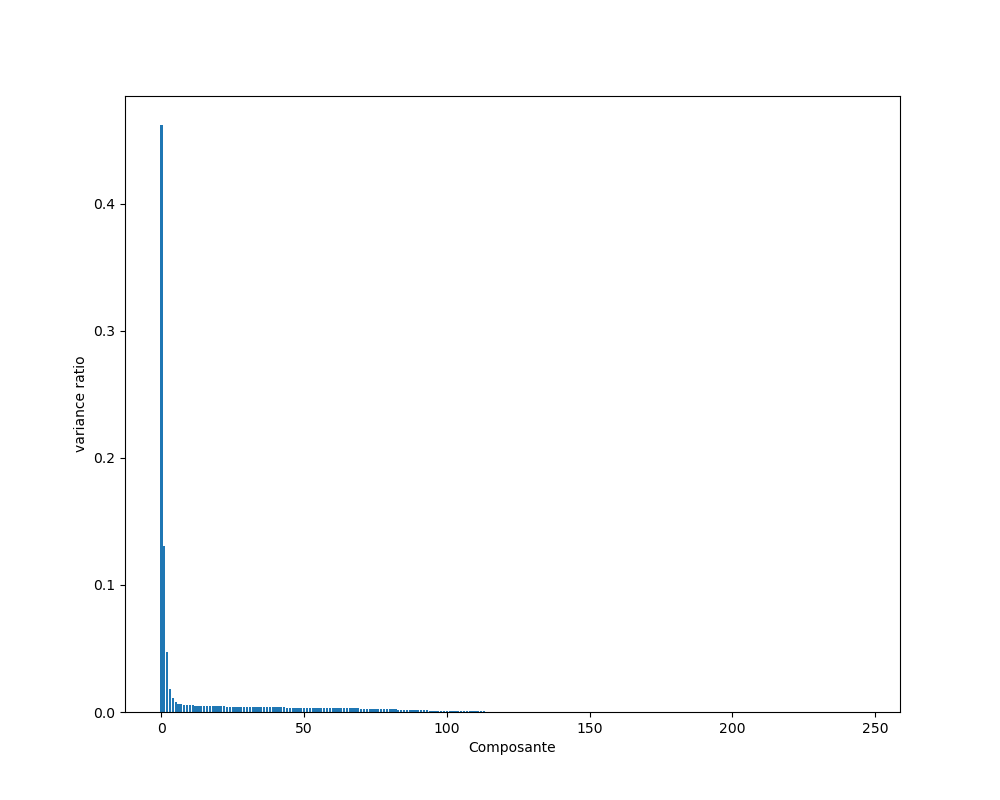

In [212]:
fig, ax = plt.subplots(figsize=(10,8))
var_ratio = pca.explained_variance_ratio_
ax.bar( range(len(var_ratio)), var_ratio )
ax.set_ylabel('variance ratio')
ax.set_xlabel('Composante')

Text(0, 0.8665112812938809, '0.87')

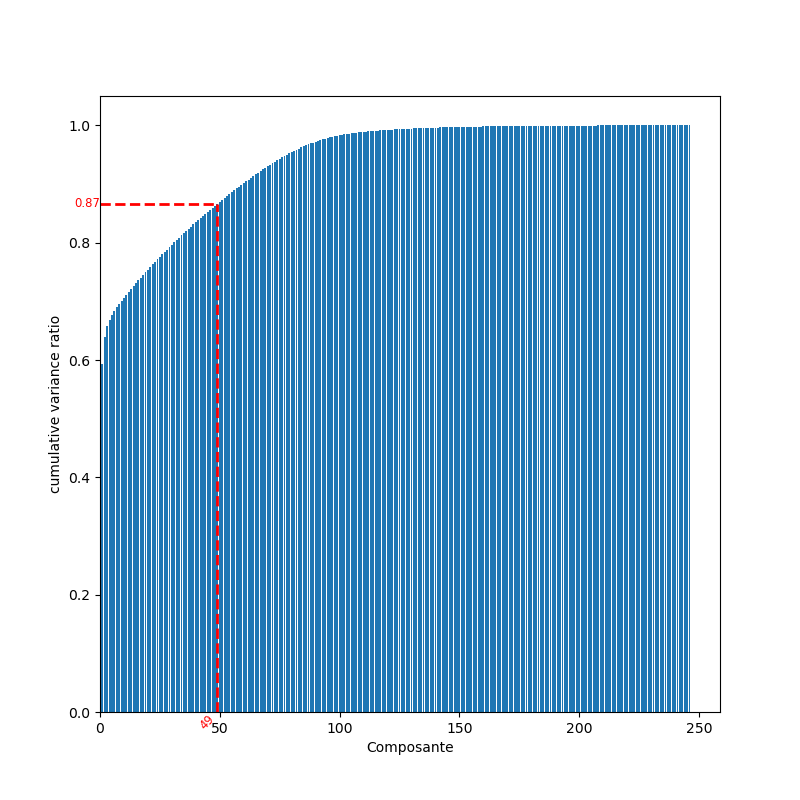

In [213]:
fig, ax = plt.subplots(figsize=(8,8))

ax.bar( range(len(var_ratio)), np.cumsum(var_ratio) )
ax.set_ylabel('cumulative variance ratio')
ax.set_xlabel('Composante')
ax.set_xlim(xmin=0)

ndim_after_pca = 50
var_ratio_tot = np.cumsum(var_ratio)[ndim_after_pca-1]

ax.plot([ndim_after_pca-1, ndim_after_pca-1], [0, var_ratio_tot], color='red', linestyle='--', linewidth=2)
ax.plot([0, ndim_after_pca-1], [var_ratio_tot, var_ratio_tot], color='red', linestyle='--', linewidth=2)
plt.text(ndim_after_pca-1, 0, f'{ndim_after_pca-1}', color='red', horizontalalignment='right', verticalalignment='top', rotation=45, fontsize='small')
plt.text(0, var_ratio_tot, f'{var_ratio_tot:.2f}', color='red', horizontalalignment='right', verticalalignment='center', fontsize='small')



In [214]:
df_reduced = new_feats[:, :ndim_after_pca]

## TSNE
Tips: https://lvdmaaten.github.io/tsne/

In [215]:
tsne = TSNE(n_components=3, perplexity=50)
X_embedded = tsne.fit_transform(df_reduced)
#X_embedded = tsne.fit_transform(df_scaled)

Text(0, 0.5, 'Variable 2')

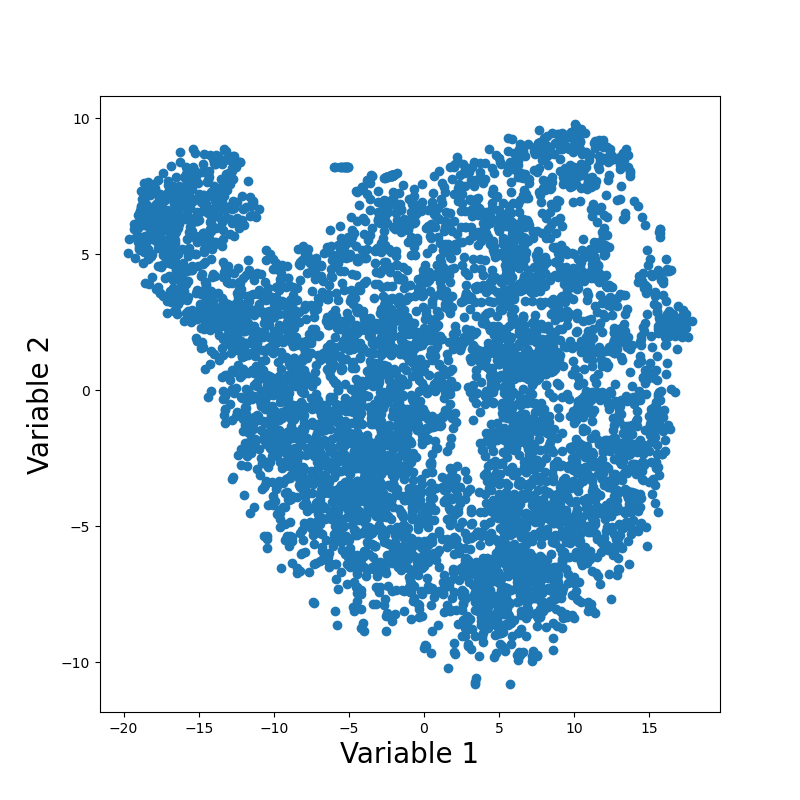

In [216]:
plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.xlabel('Variable 1', fontsize=20)
plt.ylabel('Variable 2', fontsize=20)
#plt.legend()
#plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/tsne_fertile_sterile.png')

Text(0, 0.5, 'Variable 2')

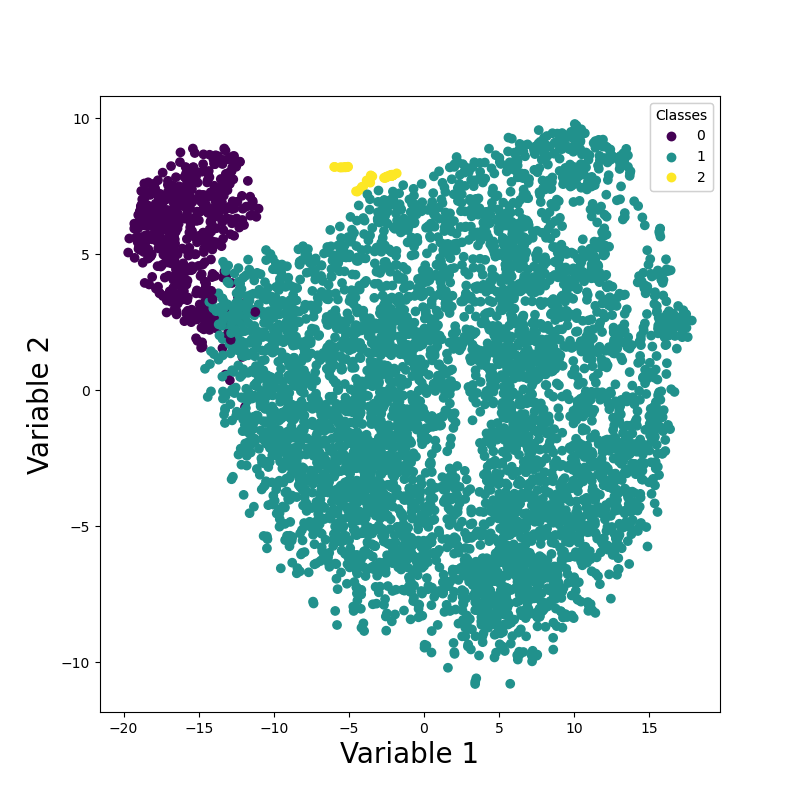

In [217]:
#clustering = DBSCAN(eps=2, min_samples=10).fit(X_embedded)
#clustering = KMeans(n_clusters=3).fit(X_embedded)
clustering = SpectralClustering(n_clusters=3,
        assign_labels='discretize',
        random_state=0).fit(X_embedded)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=clustering.labels_)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
#plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/tsne_dbscan.png')

In [218]:
tsne.kl_divergence_

1.4633499383926392

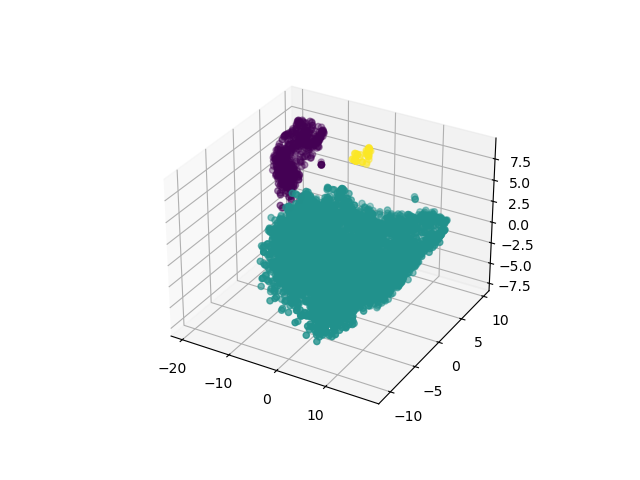

In [219]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=clustering.labels_);

On visualise les lots desquels proviennent les graines :

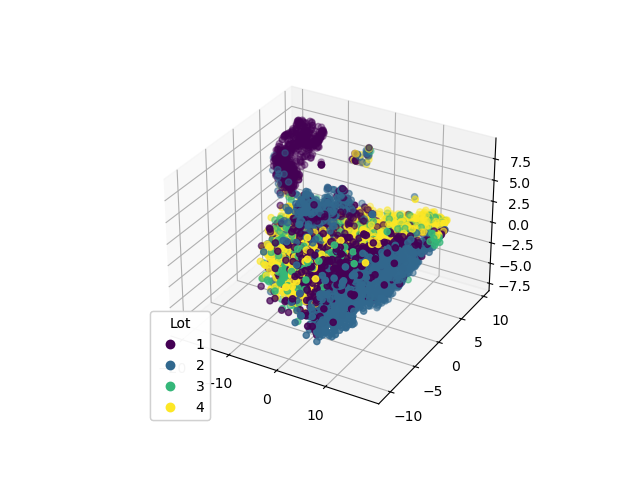

In [220]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=df_viz['Lot'])

legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Lot")
ax.add_artist(legend1)


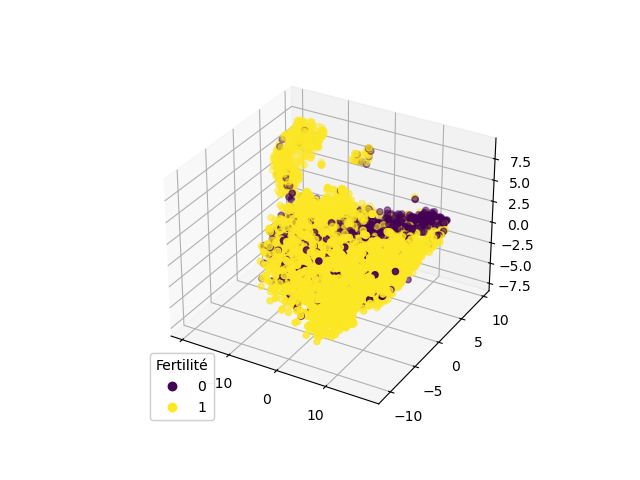

In [221]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=df_viz['Fertilité'])

legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Fertilité")
ax.add_artist(legend1)


## Cross-check with spectral embbeding and Isomap

Text(0, 0.5, 'Variable 2')

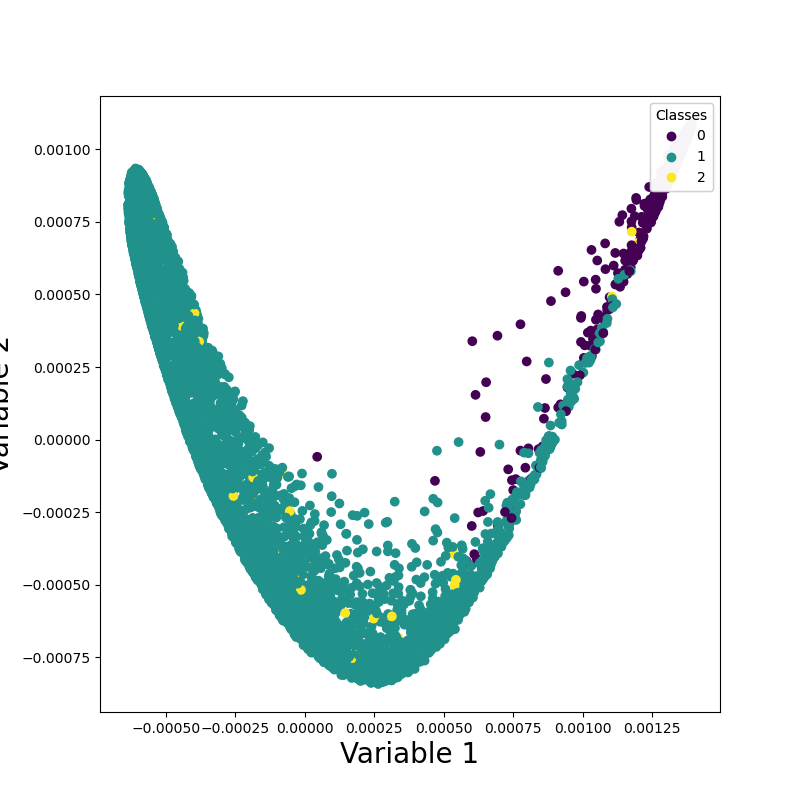

In [222]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=3)
X_transformed = embedding.fit_transform(df_scaled)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], c=clustering.labels_)
#plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
#plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/spectral_tsne_dbscan.png')

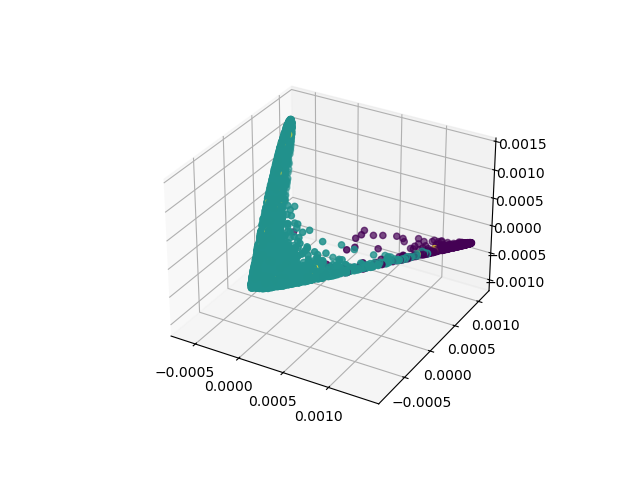

In [223]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=clustering.labels_);

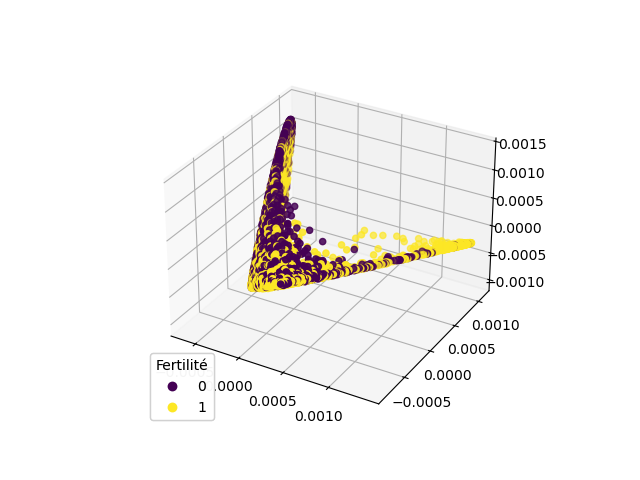

In [225]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=df_viz['Fertilité'])

legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Fertilité")
ax.add_artist(legend1)


Text(0, 0.5, 'Variable 2')

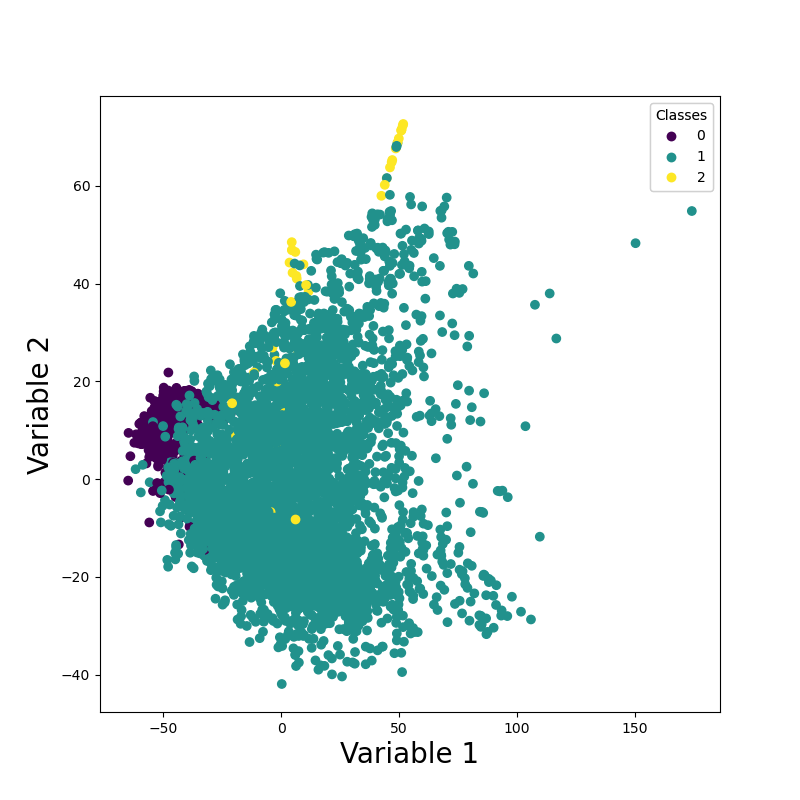

In [226]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=3)
X_transformed = embedding.fit_transform(df_scaled)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], c=clustering.labels_)
#plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
#plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/isomap_tsne_dbscan.png')

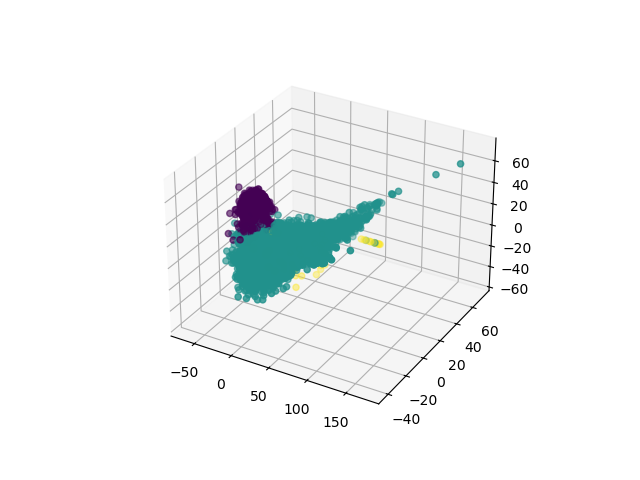

In [227]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=clustering.labels_);

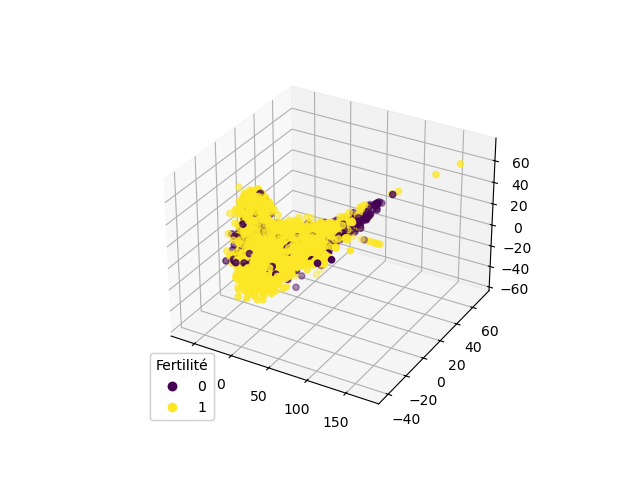

In [228]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=df_viz['Fertilité'])

legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Fertilité")
ax.add_artist(legend1)


## Explore differences between clusters

In [23]:
diff_cluster_1_vs_0 = (df_scaled[clustering.labels_ == 1].mean() - df_scaled[clustering.labels_ == 0].mean())
diff_cluster_1_vs_0.abs().sort_values()[-30:-1]

HYPVIS_641.2nm    0.650887
HYPVIS_660.0nm    0.651112
HYPVIS_668.0nm    0.653004
HYPVIS_662.6nm    0.654542
HYPVIS_721.6nm    0.658638
HYPVIS_681.4nm    0.658694
HYPVIS_729.6nm    0.662134
HYPVIS_708.2nm    0.662358
HYPVIS_657.3nm    0.669837
HYPVIS_700.2nm    0.672713
HYPVIS_678.7nm    0.676168
HYPVIS_665.3nm    0.681230
HYPVIS_686.8nm    0.690314
HYPVIS_710.9nm    0.697311
HYPVIS_638.5nm    0.706737
HYPVIS_646.6nm    0.715300
VIS_Major         0.747339
HYPVIS_654.6nm    0.749365
AvgB              2.079661
AvgA              2.250896
VIS_FeretMax      2.323783
Size              2.332164
VIS_HullArea      2.651151
VIS_HullPeri      3.098388
VIS_Minor         3.401174
VIS_FeretMin      4.314575
AvgL              4.498933
VIS_FShape        5.107723
VIS_LShape        6.046537
dtype: float64

In [24]:
diff_cluster_2_vs_0 = (df_scaled[clustering.labels_ == 2].mean() -
                       df_scaled[clustering.labels_ == 0].mean())
diff_cluster_2_vs_0.abs().sort_values()

ManualScore       0.000000
VIS_Convexity     0.008879
VIS_LShape        0.047055
VIS_FShape        0.065265
VIS_FeretMax      0.071232
                    ...   
HYPVIS_646.6nm    1.879209
HYPVIS_657.3nm    1.879916
HYPVIS_649.2nm    1.883371
HYPVIS_654.6nm    1.893941
HYPVIS_651.9nm    1.904763
Length: 247, dtype: float64

In [25]:
hypvis_cols = df_scaled.columns[23:].tolist()
hypvis_wavelengths = [float(h[-7:-2]) for h in hypvis_cols]

Text(0, 0.5, 'Cluster 2 - Cluster 0')

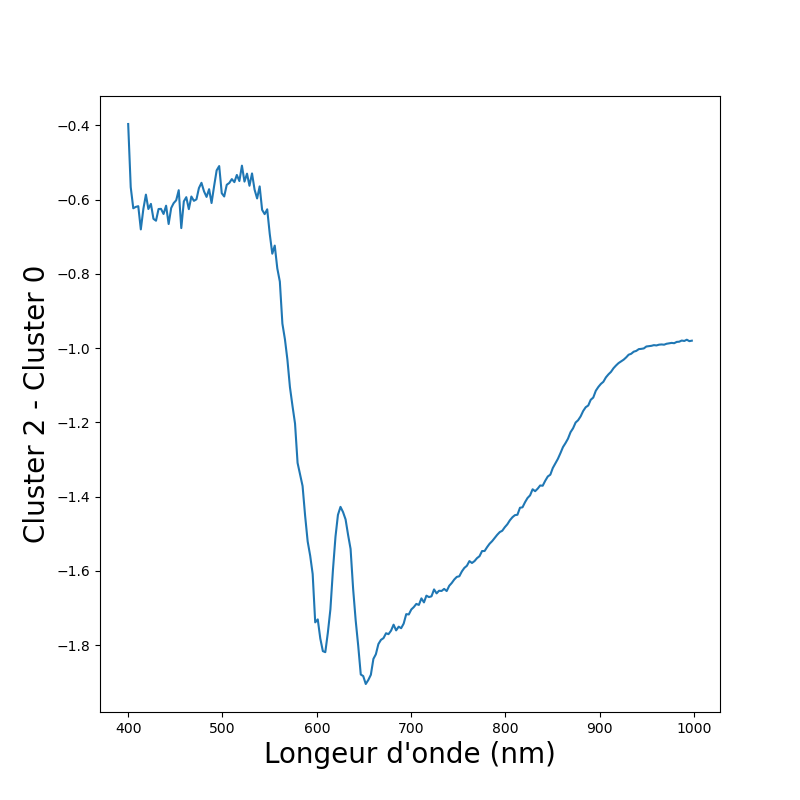

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(hypvis_wavelengths, diff_cluster_2_vs_0[hypvis_cols])
ax.set_xlabel('Longeur d\'onde (nm)', fontsize=20)
ax.set_ylabel('Cluster 2 - Cluster 0', fontsize=20)
#plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/isomap_tsne_dbscan.png')

# Méthodes supervisées

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
import shap

In [152]:
df_viz.replace(['Stérile', 'Fertile'], [0, 1], inplace=True)

In [153]:
df_viz.replace(['Non restorer', 'Restorer Hétérozygote', 'Restorer homozygote'], [0,1,2], inplace=True)

In [155]:
# remove hyperspectral data --> above index 22
x_train, x_test, df_train, df_test = train_test_split(df.iloc[:,:22], df_viz, test_size = 0.30)

In [156]:
df_train.head()

,Lot,CYTOPLASME,RF,Fertilité,ID
295,2,0,1,1.0,T04B06
768,4,0,2,1.0,T09C03
1240,1,0,1,1.0,T14C11
663,4,0,0,0.0,T08B10
1456,2,0,1,1.0,T16F08


In [200]:
# Choose the variable to use as label
label = 'Fertilité'
y_train = df_train[label]
y_test = df_test[label]

In [201]:
np.unique(y_test, return_counts=True)

(array([0., 1.]), array([ 412, 1258]))

In [202]:
# Scale data
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)

x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

## Random forest

In [203]:
clf = RandomForestClassifier(n_estimators = 1000, class_weight='balanced') 
clf.fit(x_train_scaled, y_train)
y_pred = clf.predict(x_test_scaled)
metrics.accuracy_score(y_test, y_pred)

0.9083832335329342

In [204]:
for i in np.unique(y_test):
    mask = y_test == i
    print( f'class {i} : {metrics.accuracy_score(y_test[mask], y_pred[mask]):.3f}' )

class 0.0 : 0.743
class 1.0 : 0.963


In [205]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 306,  106],
       [  47, 1211]])

In [175]:
for i in range(4):
    mask = df_test['Lot'] == i+1
    print(metrics.confusion_matrix(y_test[mask], y_pred[mask]))
    print('')

[[  0  14   1]
 [ 14 411  16]
 [  0   0   0]]

[[  0  12   0]
 [  0 489   0]
 [  0   3   0]]

[[130  14  25]
 [  0   0   0]
 [  0   0   0]]

[[249   5  25]
 [  0   0   0]
 [ 63  38 161]]



In [176]:
explainer = shap.TreeExplainer(clf)

In [177]:
shap_values = explainer(x_test_scaled.iloc[:100,:])

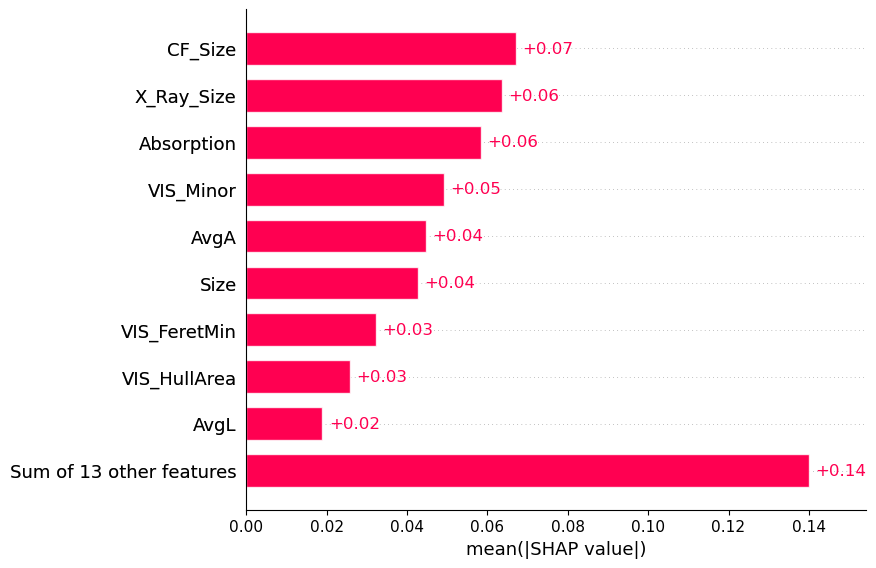

In [187]:
shap.plots.bar(shap_values[:,:,1])

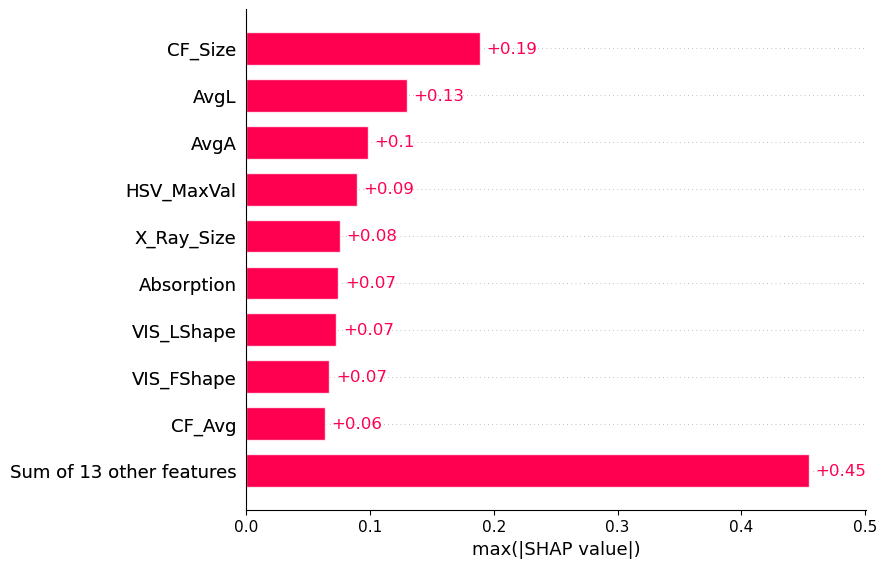

In [184]:
shap.plots.bar(shap_values[:,:,2].abs.max(0))

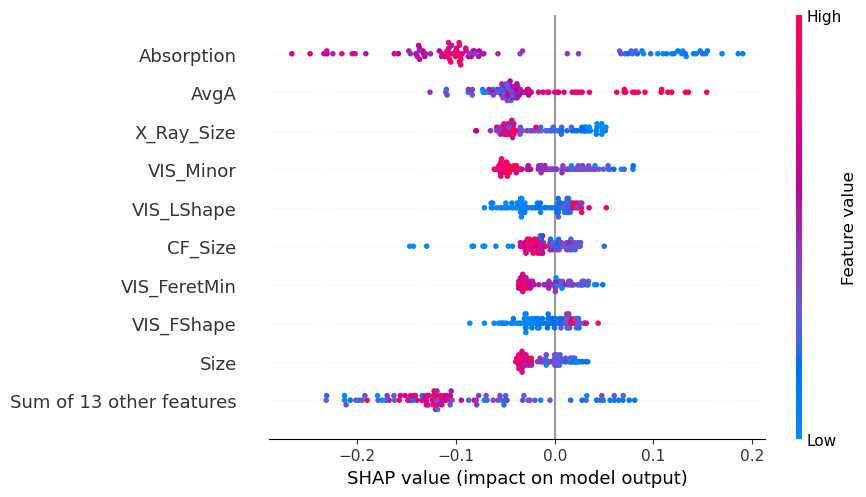

In [136]:
shap.plots.beeswarm(shap_values[:,:,0])

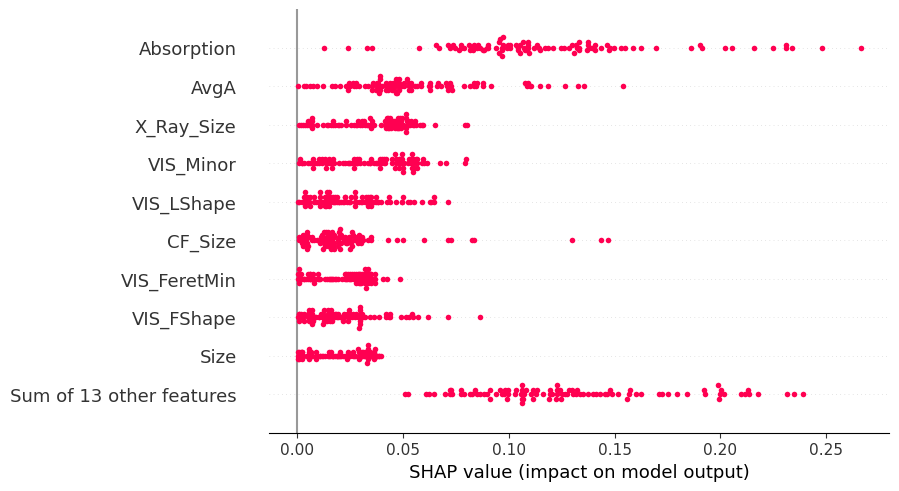

In [137]:
shap.plots.beeswarm(shap_values[:,:,1].abs, color="shap_red")

# Logistic regression

In [213]:
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_scaled, y_train)
y_pred = clf.predict(x_test_scaled)
metrics.accuracy_score(y_test, y_pred)

0.9029940119760479

In [214]:
for i in np.unique(y_test):
    mask = y_test == i
    print( f'class {i} : {metrics.accuracy_score(y_test[mask], y_pred[mask]):.3f}' )

class 0.0 : 0.721
class 1.0 : 0.963


In [215]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 297,  115],
       [  47, 1211]])

In [212]:
explainer = shap.KernelExplainer(clf.predict_proba, x_train_scaled)

Using 3894 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
